In [14]:
import numpy as np
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

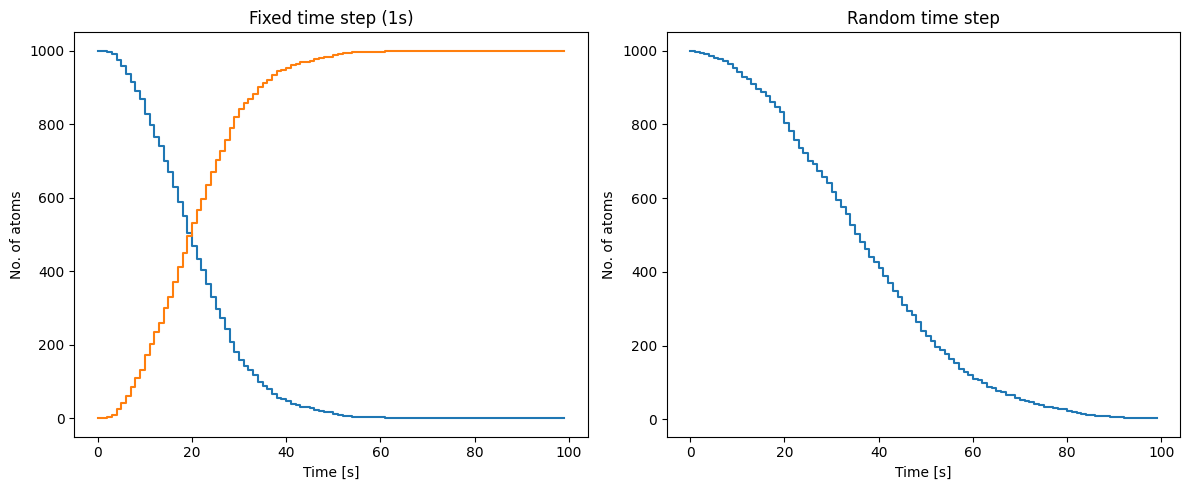

In [327]:
# Initial Thallium atoms sample
sample = 1000

np.random.seed(420)

thalium = np.full(sample, sample)
lead = np.full(sample,0)
time = np.arange(0,sample, dtype='int')

# Decay probability
def p(t,tau=3.052*60): # tau [s]
    return 1 - 2**(-t/tau)

# Time steps of 1 second
for t in time[1:]:
    decay = np.random.rand(thalium[t-1]) < p(t-1)

    thalium[t] = thalium[t-1] - np.sum(decay)
    lead[t] = lead[t-1] + np.sum(decay)

# Plot
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))  
ax[0].step(time[:100],thalium[:100],where='post')       
ax[0].step(time[:100],lead[:100],where='post')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('No. of atoms')
ax[0].set_title('Fixed time step (1s)')

# Integrating p(t) = 2^(-t/tau)*ln(2)/tau from 0 to t we get P(t) = 1 - 2^(-t/tau)
# Time of decay probability (inverse of P(t))
def invp(p,tau=3.052*60): # tau [s]
    return -tau * np.log2(1 - p)

# Sample times of decay using inverse transform method
u = np.random.rand(sample)
decay_time = np.sort(invp(u))
atoms = np.full(sample, sample)

# Random time steps
for i in range(1,len(decay_time)):
    decay = np.random.rand(atoms[i-1]) < p(decay_time[i-1])
    
    atoms[i] = atoms[i-1] - np.sum(decay)
    
# Plot
ax[1].step(time[:100], atoms[:100], where='post')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('No. of atoms')
ax[1].set_title('Random time step')

plt.tight_layout()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

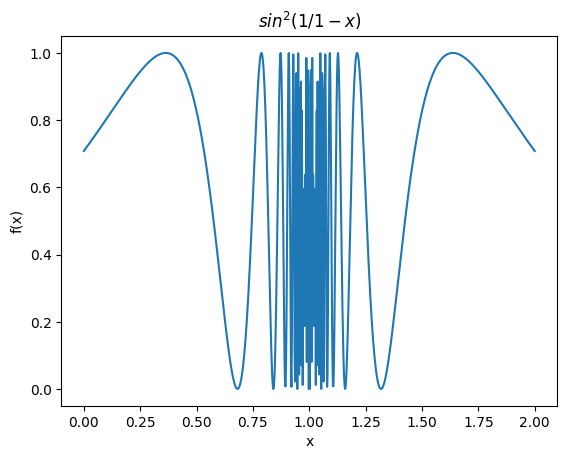

In [653]:
def f(x):
    return (np.sin(1 / (1-x)))**2

# Plot function
x = np.linspace(0, 2, 1000)
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('$sin^{2} (1/1-x)$')

n = 1000
N = 1000
a, b, h = 0, 2, 1

In [657]:
np.random.seed(390)

def hitmiss_method(a, b, h, n):
    count = 0
    
    for i in range(n):
        x = (b - a) * np.random.random()
        y = h * np.random.random()

        if y < f(x): count += 1

    return count / n * h * (b-a)

def calc_sigma_hm(a, b, h, n, N):
    integr = np.array([hitmiss_method(a, b, h, n) for m in np.arange(N)])
    sigma = np.sqrt(np.mean(integr**2) - np.mean(integr)**2)
    
    return sigma

I = hitmiss_method(a, b, h, n)
sigma = np.sqrt(calc_sigma_hm(a, b, h, n, N)) / np.sqrt(N)
print("Hit/Miss method I = %.4f +- %.4f" % (I, sigma))

Hit/Miss method I = 1.3380 +- 0.0054


In [656]:
np.random.seed(390)

def mean_value_method(a, b, n):
    xi = np.random.uniform(a, b, n) 
    return (b - a) / n * np.sum(f(xi))

def calc_sigma_mv(a, b, n, N):
    integr = np.array([mean_value_method(a, b, n) for mi in np.arange(N)])
    sigma = np.sqrt(np.mean(integr**2) - np.mean(integr)**2)
    return sigma

I = mean_value_method(a, b, n)
sigma = np.sqrt(calc_sigma_mv(a, b, n, N)) / np.sqrt(N)
print("Mean value I = %.4f +- %.4f" % (I, sigma))

Mean value I = 1.3454 +- 0.0045


Text(0.5, 1.0, 'Hit/Miss vs Mean Value')

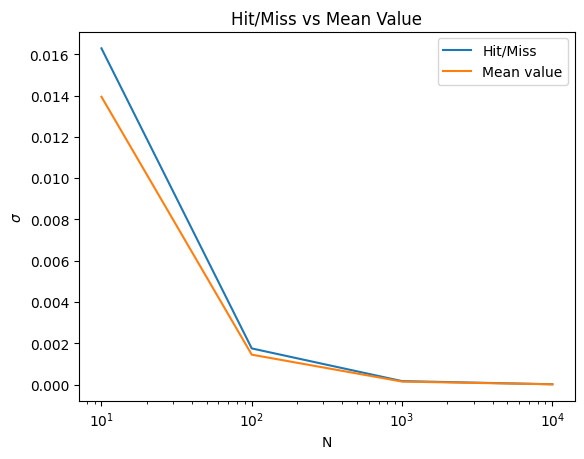

In [658]:
Ns = np.array([10, 100, 1000, 10000])

sigmas_hm = np.array([(np.sqrt(calc_sigma_hm(a, b, h, n, ni)) / ni) for ni in Ns])
sigmas_mv = np.array([(np.sqrt(calc_sigma_mv(a, b, n, ni)) / ni) for ni in Ns])

plt.plot(Ns, sigmas_hm, label='Hit/Miss')
plt.plot(Ns, sigmas_mv, label='Mean value')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('$\sigma$')
plt.legend(loc='best')
plt.title("Hit/Miss vs Mean Value")

# Mean value method is faster and slightly more accurate than hit/miss method.

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [660]:
def f(*args):
    sum = np.sum(np.array(args)**2, axis=1)
    return np.where(sum <= 1, 1, 0)

# Compute volume of a N-D sphere using mean value (Monte Carlo) method
def integrate_unit_circle(r, d, n):
    x = np.random.uniform(-r, r, (d,n))
    s = np.sum(f(x))
    return (2*r)**d / n * s

n = 1000000
r = 1

print("Integral of a circle of unit radius I = %.4f" % integrate_unit_circle(r, 2, n))
print("Integral of a 3D sphere of unit radius I = %.4f" % integrate_unit_circle(r, 3, n))
print("Integral of a 10D sphere of unit radius I = %.4f" % integrate_unit_circle(r, 10, n))

Integral of a circle of unit radius I = 3.1397
Integral of a 3D sphere of unit radius I = 4.1857
Integral of a 10D sphere of unit radius I = 2.4863


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [646]:
def f(x):
    return x**(-0.5) / (np.exp(x) + 1)

# Normalized weight function (w(x) divided by integral from 0 to 1 of w(x))
def w(x):
    return 1 / (2 * np.sqrt(x))

# CDF
def W(x):
    return np.sqrt(x)

# inverse CDF
def iW(u):
    return u**2

N = 10000
a, b = 0, 1

# Inverse transform method
u = np.random.uniform(a, b, N)
xi = iW(u)

I = (1 / N ) * np.sum(f(xi) / w(xi)) * (W(b) - W(a))
print("With importance sampling I = %.4f" % I)

I = (1 / N ) * np.sum(f(u)) * (b - a)
print("Without importance sampling I = %.4f" % I)

With importance sampling I = 0.8404
Without importance sampling I = 0.8295
